# Mobile Subscribers Churn Prediction

About this project

Before we start, it is important mention that the project not only covers the process of **Retrieving the data**, **Manipulating it**, and **Ingesting it** into the **Machine Learning Model**, but also some additional steps with statistical methods, such as **Handling Imbalanced Data**, as well as **Visualizations** to effectively predict whether a subscriber will become "silent" or not.

For this specific dataset, the churn column represents customers who have become "silent," meaning that they have no activity within the company's mobile network, no data, text messages, or calls. This condition is maintained for a period of time until the line can be canceled and reused.

**Inserting libreries and exploring the dataset**

The first step in the implementation of the project was to install de libreries and insert the dataset into the Jupyter notebook. The dataset is in a CSV format, so we used the read_csv() function from Pandas to read it into a DataFrame.

In [1]:
# For data manipulation
import sqlite3 as sq
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For handing imbalanced data if necessary
from imblearn.over_sampling import SMOTE

# For data splitting, transforming and model training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# For model evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

With the necessary libraries installed, we proceed to import the dataset into the notebook. Using **df.info()** and **df.describe()** we obtain all the information about how the dataframe is structured, observing that it consists of 14 columns of either INTEGER or REAL data types without null values (at first glance).

In [3]:
df=pd.read_csv('customer_churn.csv')
df.head(10)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
5,11,0,38,1,3775,82,32,28,3,1,1,30,282.280,0
6,4,0,38,0,2360,39,285,18,3,1,1,30,1235.960,0
7,13,0,37,2,9115,121,144,43,3,1,1,30,945.440,0
8,7,0,38,0,13773,169,0,44,3,1,1,30,557.680,0
9,7,0,38,1,4515,83,2,25,3,1,1,30,191.920,0


Among the 14 columns, we can quickly identify that some of them will not have a major contribution to the model, so we remove **call_failure**, **subscription_length**, **charge_amount**, and **tariff_plan**.

In [4]:
df = df.drop(columns=['Call Failure', 'Subscription Length', 'Charge Amount', 'Tariff Plan'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Complains                3150 non-null   int64  
 1   Seconds of Use           3150 non-null   int64  
 2   Frequency of use         3150 non-null   int64  
 3   Frequency of SMS         3150 non-null   int64  
 4   Distinct Called Numbers  3150 non-null   int64  
 5   Age Group                3150 non-null   int64  
 6   Status                   3150 non-null   int64  
 7   Age                      3150 non-null   int64  
 8   Customer Value           3150 non-null   float64
 9   Churn                    3150 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 246.2 KB


In [6]:
df.describe()

,Complains,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Status,Age,Customer Value,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,0.076508,4472.459683,69.460635,73.174921,23.509841,2.826032,1.248254,30.998413,470.972916,0.157143
std,0.265851,4197.908687,57.413308,112.237560,17.217337,0.892555,0.432069,8.831095,517.015433,0.363993
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,25.000000,113.801250,0.000000
50%,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,30.000000,228.480000,0.000000
75%,0.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,30.000000,788.388750,0.000000
max,1.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,55.000000,2165.280000,1.000000


Now, taking the result of **df.describe**, we observe that all the numerical columns have a minimum of 0. We could think that these are new customers who are just joining the network, but it is worth exploring to eliminate the doubt of whether this is true or if they are actually missing values.

**Data Analysis**

In [9]:
# Create a new variable to observe where the 0 values are located
data_zero = df[df['Seconds of Use'] == 0]
data_zero

,Complains,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Status,Age,Customer Value,Churn
18,0,0,0,0,0,2,2,25,0.0,1
118,0,0,0,0,0,2,2,25,0.0,1
128,1,0,0,0,0,3,2,30,0.0,1
132,0,0,0,0,0,5,1,55,0.0,0
201,0,0,0,0,0,2,2,25,0.0,0
...,...,...,...,...,...,...,...,...,...,...
2868,0,0,0,0,0,2,2,25,0.0,1
3001,0,0,0,0,0,3,2,30,0.0,0
3018,0,0,0,0,0,2,2,25,0.0,1
3028,0,0,0,0,0,3,2,30,0.0,1


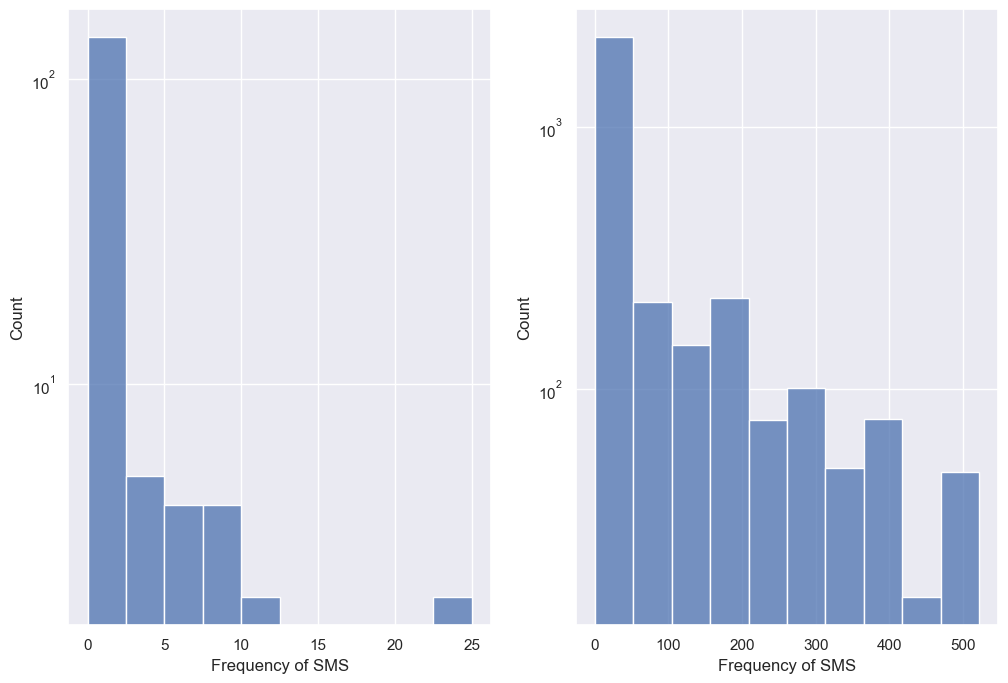

In [10]:
# Use Seaborn to plot the values of the SMS frequency
sns.set()
fig,ax = plt.subplots(1, 2, figsize=(12,8))
sns.histplot(x='Frequency of SMS', data=zero_data, ax=ax[0], bins=10)
sns.histplot(x='Frequency of SMS', data=df, ax=ax[1], bins=10)
ax[0].set(yscale='log')
ax[1].set(yscale='log')
plt.show()

At first glance, there is a clear difference between both graphs. The graph on the right shows the data associated with when **seconds_of_use** is equal to 0 and the graph on the left, the entire dataset. Therefore, while the first has a maximum value of **25**, in the second the value goes up to **500** SMS, which indicates that they are not empty spaces but new subscribers who are just starting their consumption history.

With this resolved, we move on to explore how correlated the values are with each other, in order to continue cleaning our data to obtain the best possible result.

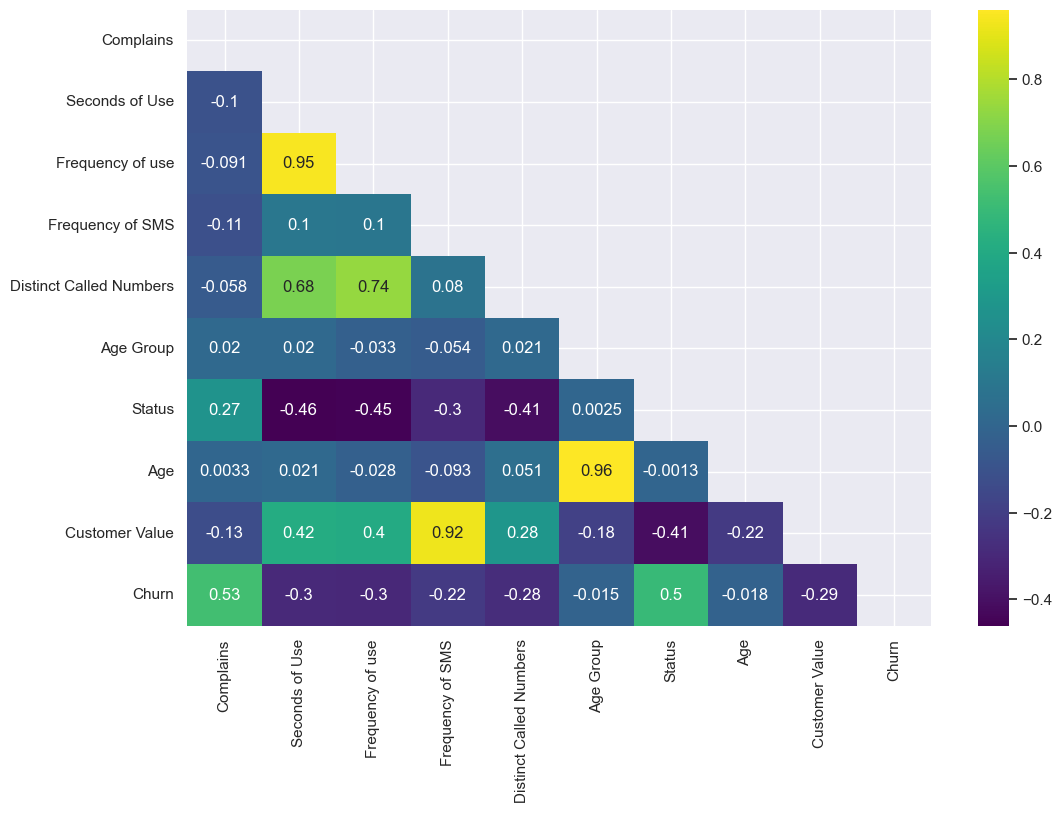

In [11]:
# Correlation matrix
plt.figure(figsize=(12,8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask, cmap='viridis')
plt.show()

From the matrix, we can note that **frequency_of_use** and **seconds_of_use** 
have a high positive correlation between them, so we remove one of them.

In [12]:
df = df.drop(columns=['Frequency of use'])
df

,Complains,Seconds of Use,Frequency of SMS,Distinct Called Numbers,Age Group,Status,Age,Customer Value,Churn
0,0,4370,5,17,3,1,30,197.640,0
1,0,318,7,4,2,2,25,46.035,0
2,0,2453,359,24,3,1,30,1536.520,0
3,0,4198,1,35,1,1,15,240.020,0
4,0,2393,2,33,1,1,15,145.805,0
...,...,...,...,...,...,...,...,...,...
3145,0,6697,92,44,2,1,25,721.980,0
3146,0,9237,80,42,5,1,55,261.210,0
3147,0,3157,38,21,3,1,30,280.320,0
3148,0,4695,222,12,3,1,30,1077.640,0


Satisfied with our dataset, we will now look to check how balanced our data is from the perspective of our churn variable.

**Cheking imbalanceness**

Now we are going to check how much data are present for churned and non-churned customers.

In [14]:
# Create two new test variables
churned = df[df['Churn']==1]
not_churned = df[df['Churn']==0]

print('percentage of churned customer: {}'.format(churned.shape[0]/df.shape[0]))
print('percentage of not-churned customer: {}'.format(not_churned.shape[0]/df.shape[0]))

percentage of churned customer: 0.15714285714285714
percentage of not-churned customer: 0.8428571428571429


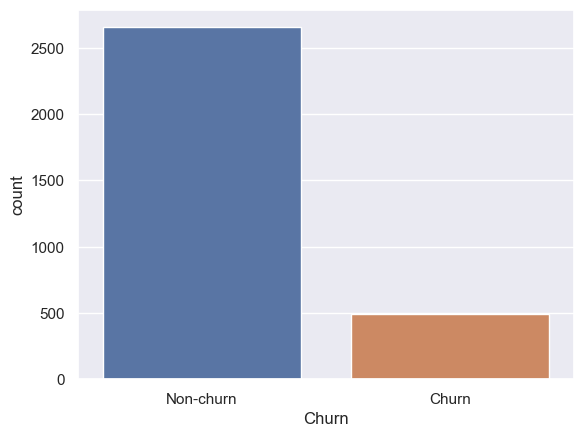

In [18]:
# We can also see it graphically
sns.countplot(x='Churn', data=df)
plt.xticks([0, 1], ['Non-churn', 'Churn'])
plt.show()

As we can see, the result is not a surprise. Only **15%** of the data is related to subscribers who became silent. Here is where we need to use **SMOTE** (Synthetic Minority Over-sampling Technique), which will allow us to create synthetic data with the sole purpose of leveling the data for the training part of the model. For the model, we will not take them into account.

In [19]:
from collections import Counter

# splitting the data as X and y
X = df.drop('Churn', axis=1)
y = df['Churn']

# making a SMOTE object
resampler = SMOTE(random_state=5)

# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# resampling the data
X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

# verifying the resampled data
print('Resampled dataset shape %s' % Counter(y_resampled))

Resampled dataset shape Counter({0: 2124, 1: 2124})


Now that our data is balanced, we need to scale the columns **seconds_of_use**, **frequency_of_sms**, and **customer_value** to categorical columns before training a model.

In [20]:
# Making a ColumnTransformer object
ct = ColumnTransformer(
    [('scaler', StandardScaler(), ['Seconds of Use', 'Frequency of SMS', 'Customer Value'])], remainder='passthrough')

# Transforming the data
X_scaled = ct.fit_transform(X_resampled)
X_test_scaled = ct.transform(X_test)

**Model Training**

For our model, we will use a logistic regression model.

In [22]:
# Creating an object for LogisticRegression
linear_reg = LogisticRegression(max_iter=1000000)

# Fitting the data
linear_reg.fit(X_scaled, y_resampled)

# Predicting on x_test
y_pred = linear_reg.predict(X_test_scaled)

In [23]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       531
           1       0.50      0.88      0.64        99

    accuracy                           0.84       630
   macro avg       0.74      0.86      0.77       630
weighted avg       0.90      0.84      0.86       630



With this report, we can see that the model achieves a decent result in predicting which customers will become silent, based on the actual data.

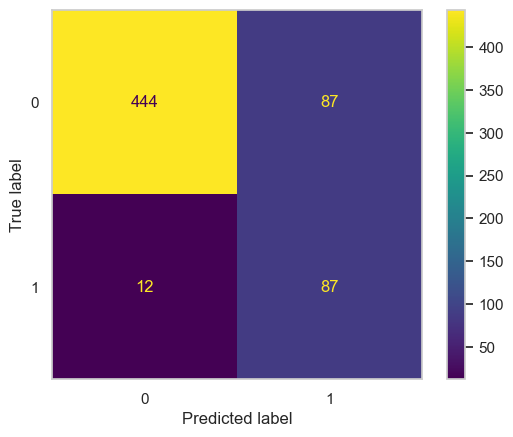

In [24]:
# lets removes the grid from the confusion matrix
sns.set_style("whitegrid", {'axes.grid' : False})

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Of the 99 silent subscribers, we correctly detected **85** and **14** were misclassified. This result may change in multiple reruns.

**Future Improvements**

This model can be improved by using other algorithms other than LogisticRegression or applying Cross-Validation to find the best split of the data for training.

**Second scenario**

What would be the result of the model whithout the resampling?

In [25]:
# The data without resampling
X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)

# Fitting and predicting the model
linear_reg.fit(X_train_scaled, y_train)
y_pred2 = linear_reg.predict(X_test_scaled)

print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       531
           1       0.91      0.49      0.64        99

    accuracy                           0.91       630
   macro avg       0.91      0.74      0.80       630
weighted avg       0.91      0.91      0.90       630



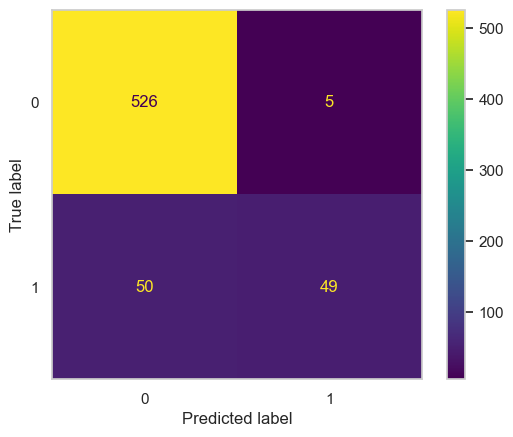

In [26]:
# Lets removes the grid from the confusion matrix
sns.set_style("whitegrid", {'axes.grid' : False})

ConfusionMatrixDisplay.from_predictions(y_test, y_pred2)
plt.show()

Comparatively, we see that the model does not have the same effectiveness in detecting silent subscribers.